In [175]:
import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import display, clear_output

import os
import re
import time
import warnings
import string
import gzip
import json
from collections import defaultdict
from tqdm import tqdm
import pickle as pkl

import numpy as np
import pandas as pd
#from scipy.spatial import procrustes
import scipy.spatial

from Bio.PDB import *

In [168]:
def load_pdb(path):
  fpaths = []
  for root, dirs, files in os.walk(path):
    for fname in files:
      if not re.match(r'.*\.pdb\.gz$', fname):
        continue
      fpath = os.path.join(root, fname)
      fpaths.append(fpath)
  parser = PDBParser()
  data = []
  for fpath in tqdm(fpaths[:]):
    with gzip.open(fpath, 'rt') as f:
      with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        structure = parser.get_structure(re.search('.*/pdb([\w\W\d]+)\.pdb.gz', fpath).group(1), f)
  
      chains = []
      for model in structure:
        for chain in model:
          atoms = np.concatenate([
            np.stack([
              a.get_coord() for a in r.get_atoms()
            ])
            for r in list(chain)
          ], axis=0)
          atom_residues = np.concatenate([
            np.stack([
              r.resname for a in r.get_atoms()
            ])
            for r in list(chain)
          ], axis=0)
          chains.append({
            'chain': chain,
            'atoms': atoms,
            'atom_residues': atom_residues,
          })
      data.append({
        'structure': structure,
        'chains': chains,
      })
  return data
      
pdbs = load_pdb('./data/pdb')

100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


In [169]:
list(pdbs[0]['chains'][0]['chain'])[0].resname

'THR'

In [170]:
import nglview as nv
view = nv.show_biopython(pdbs[1]['structure'])
view

NGLWidget()

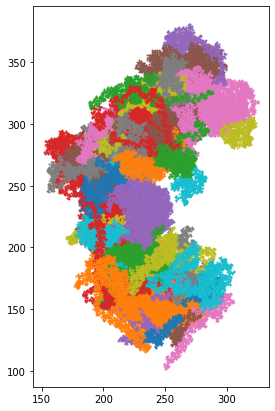

In [171]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_aspect('equal')
for chain in pdbs[1]['chains']:
  ax.scatter(chain['atoms'][:,0], chain['atoms'][:,2], s=1)

In [172]:
approximating_spheres = []
for chain in pdbs[1]['chains']:
  approximating_spheres.append(np.concatenate([
    np.mean(chain['atoms'], axis=0),
    [np.mean(np.std(chain['atoms'], axis=0))],
  ]))

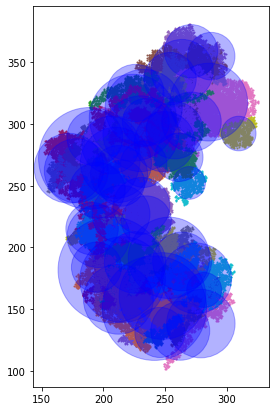

In [173]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_aspect('equal')
for chain, approximating_sphere in zip(pdbs[1]['chains'], approximating_spheres):
  ax.scatter(chain['atoms'][:,0], chain['atoms'][:,2], s=1)
  
  c = plt.Circle(
    (approximating_sphere[0], approximating_sphere[2]),
    radius=approximating_sphere[3] * 2,
    color='blue',
    alpha=.3
  )
  ax.add_artist(c)

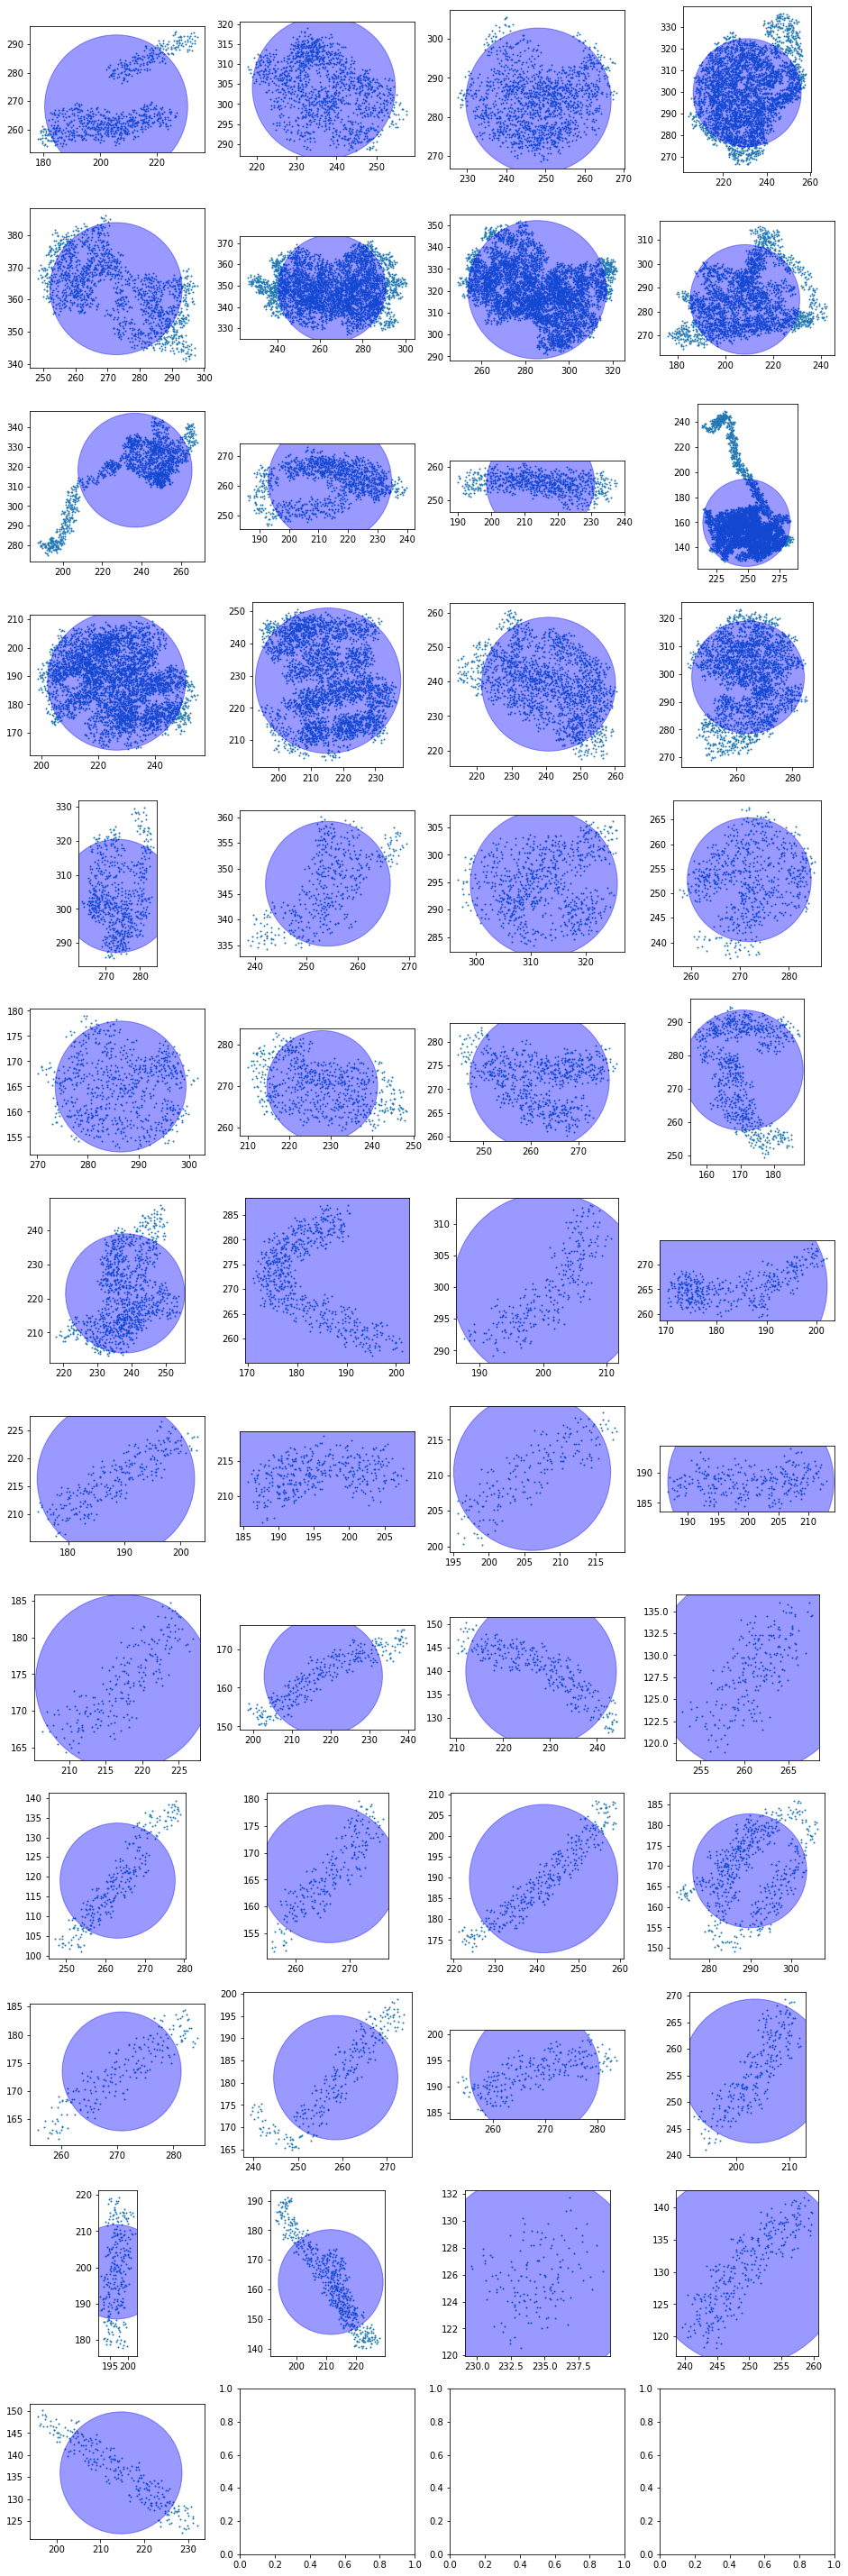

In [159]:
row_size = 4
row_count = int(np.maximum(np.ceil(len(pdbs[1]['chains']) / row_size), 2))
fig, ax = plt.subplots(row_count, row_size, figsize=(4 * row_size, 4 * row_count))
for i, (chain, approximating_sphere) in enumerate(zip(pdbs[1]['chains'], approximating_spheres)):
  ax[i // row_size][i % row_size].set_aspect('equal')
  ax[i // row_size][i % row_size].scatter(chain['atoms'][:,0], chain['atoms'][:,2], s=1)
  
  c = plt.Circle(
    (approximating_sphere[0], approximating_sphere[2]),
    radius=approximating_sphere[3] * 2,
    color='blue',
    alpha=.4
  )
  ax[i // row_size][i % row_size].add_artist(c)

In [178]:
interaction_map = defaultdict(list)

chain_trees = []
for i, ichain in enumerate(pdbs[1]['chains']):
  chain_trees.append(scipy.spatial.cKDTree(ichain['atoms']))

for i, ichain in enumerate(pdbs[1]['chains']):
  print(i)
  for j, jchain in enumerate(pdbs[1]['chains']):
    if i == j:
      continue
    for a in ichain['atoms']:
      interaction_partners = chain_trees[j].query_ball_point(a, 3.0)
      if len(interaction_partners) > 0:
        interaction_map[i].append(j)
        break
  if len(interaction_map[i]) < 1:
    print('Chain {0} has no interaction partners!'.format(i))
                     
#   for j, jchain in enumerate(pdbs[1]['chains']):
#     if i == j:
#       continue
#     # TODO: skip reciprocal (duplicating) checks
#     dists = np.linalg.norm(np.expand_dims(jchain['atoms'], axis=1) - np.expand_dims(ichain['atoms'], axis=0), axis=2)
#     #print(np.min(dists))
#     # For now, just do arbitraty atom distance check, no hydrogen bond calculation
    
#     # Hydrogen bonds refs
#     # https://amber-md.github.io/pytraj/latest/tutorials/basic_examples.html#hbond-analysis
#     # https://docs.mdanalysis.org/stable/_modules/MDAnalysis/analysis/hbonds/hbond_analysis.html
    
#     if np.sum(dists < 3.0) > 0:
#       interaction_map[i].append(j)
# #     elif np.sum(dists < 4.0) > 0:
# #       interaction_map[i].append(j)
# #       print('Chains {0} and {1} do not interact at 3 angstroms, but do at 4'.format(i, j))
#   if len(interaction_map[i]) < 1:
#     print('Chain {0} has no interaction partners!'.format(i))
  # TODO: detect disconnected interaction graphs
interaction_map

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


defaultdict(list,
            {0: [1, 2, 3, 7, 9, 10, 13, 15, 22, 25, 27, 30],
             1: [0, 2, 3, 7, 8, 15, 22, 42],
             2: [0, 1, 3, 6, 8, 15, 16, 21, 22, 43],
             3: [0, 1, 2, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17, 21, 22, 25, 43],
             4: [5, 6, 44],
             5: [4, 6, 16, 43, 44],
             6: [2, 3, 4, 5, 8, 15, 16, 17, 18, 22, 42, 43],
             7: [0, 1, 3, 8, 9, 15, 23, 25, 26, 27, 42],
             8: [1, 2, 3, 6, 7, 15, 16, 17, 25, 26, 27, 42, 43],
             9: [0, 7, 10, 13, 15, 22, 25, 26, 27, 30],
             10: [0, 3, 9, 11, 13, 30],
             11: [3,
              10,
              12,
              13,
              20,
              24,
              32,
              33,
              34,
              35,
              36,
              37,
              38,
              39,
              40,
              41],
             12: [3, 11, 13, 14, 23, 24, 29, 31, 32, 33, 37, 38, 39, 41],
             13: [0, 3, 9, 10, 11,

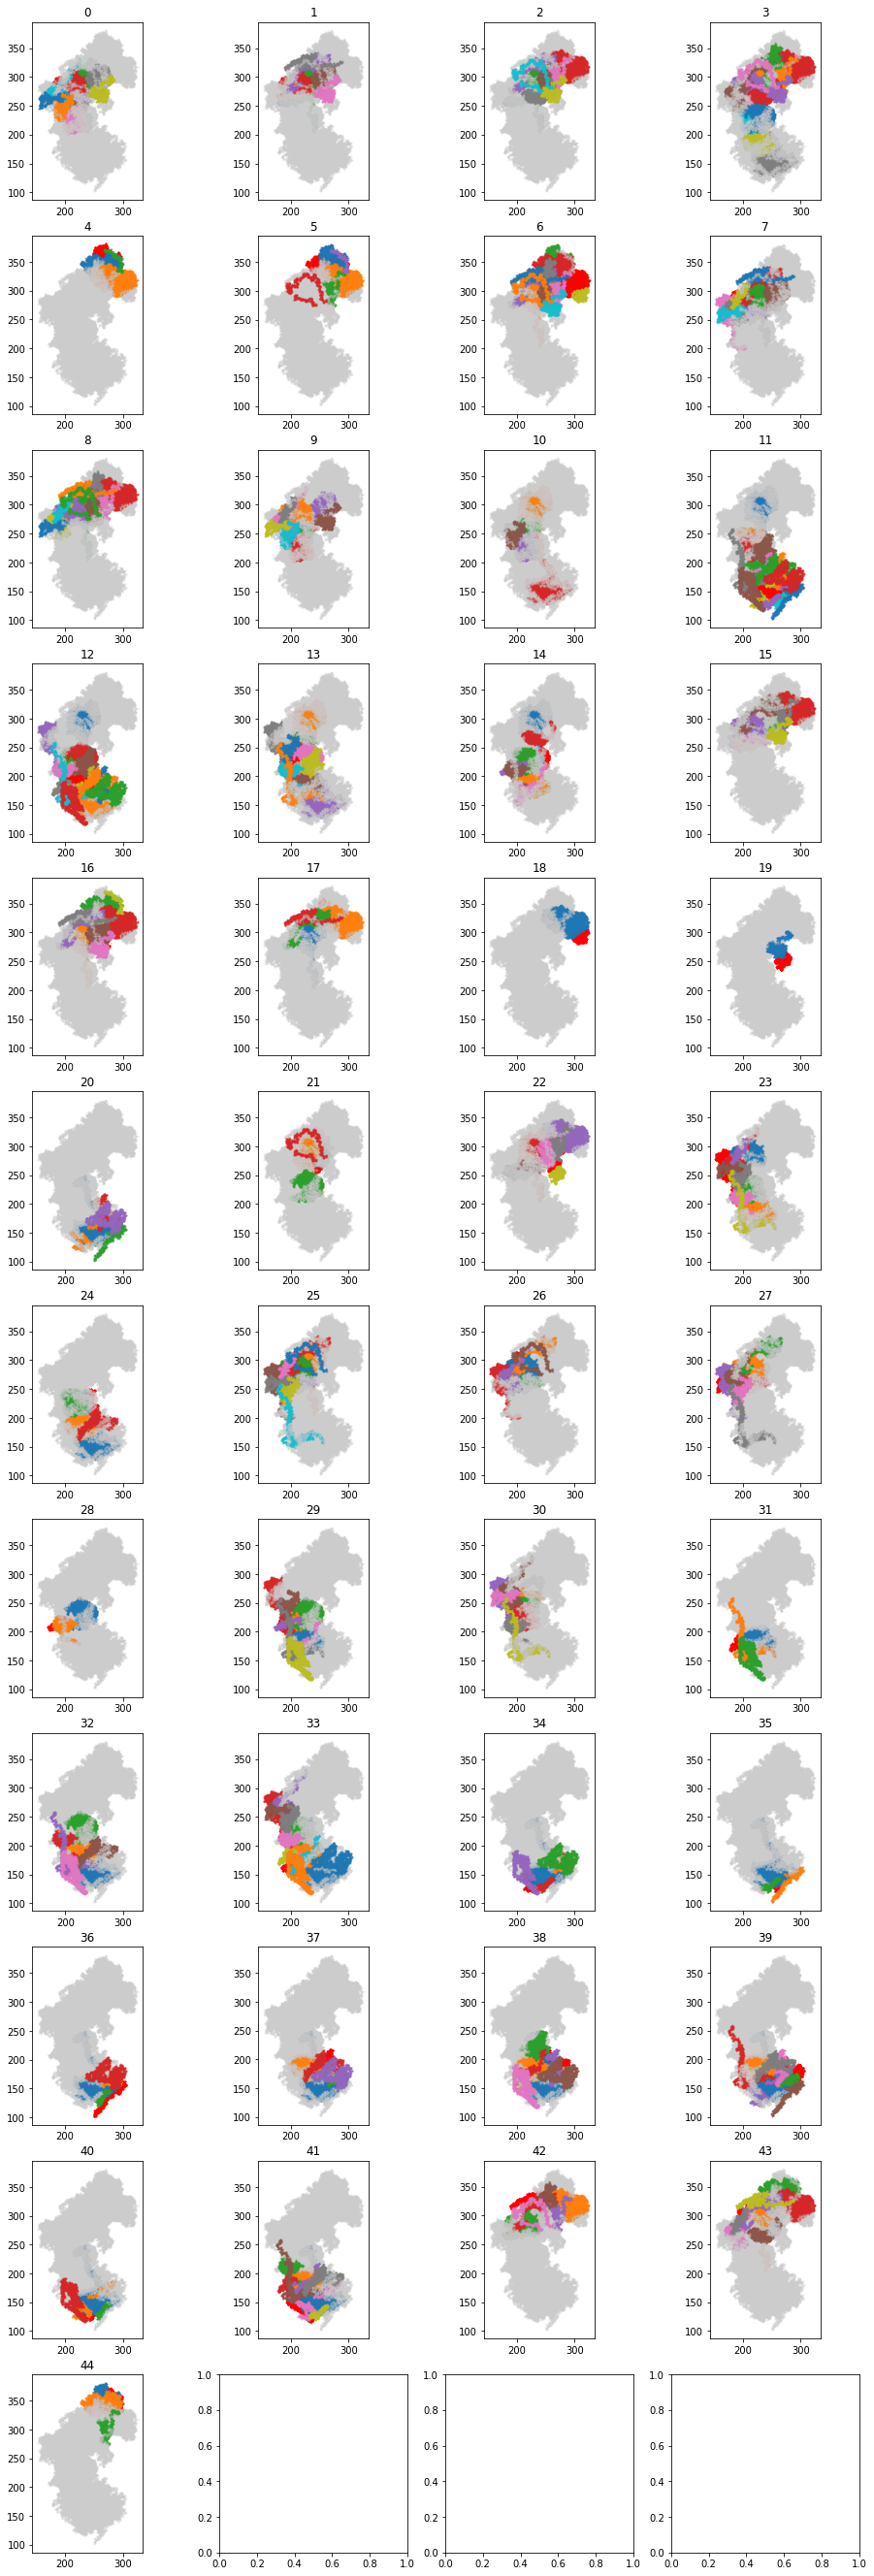

In [179]:
# Plot the interacting residue groups.
# Current residue is the reddest one, interaction partners are colored, and the rest are grey
row_size = 4
row_count = int(np.maximum(np.ceil(len(pdbs[1]['chains']) / row_size), 2))
fig, ax = plt.subplots(row_count, row_size, figsize=(4 * row_size, 4 * row_count))
for i, (chain, approximating_sphere) in enumerate(zip(pdbs[1]['chains'], approximating_spheres)):
  ax[i // row_size][i % row_size].set_aspect('equal')
  ax[i // row_size][i % row_size].scatter(chain['atoms'][:,0], chain['atoms'][:,2], s=1, color=[1, 0, 0])
  ax[i // row_size][i % row_size].set_title(i)
  
  for j, jchain in enumerate(pdbs[1]['chains']):
    if i == j:
      continue
    if j in interaction_map[i]:
      ax[i // row_size][i % row_size].scatter(jchain['atoms'][:,0], jchain['atoms'][:,2], s=1, alpha=.4)
    else:
      ax[i // row_size][i % row_size].scatter(jchain['atoms'][:,0], jchain['atoms'][:,2], s=1, color=[.8, .8, .8], alpha=.1)

In [90]:
# Kyte & Doolitle, ref: https://web.expasy.org/protscale/pscale/Hphob.Doolittle.html
residue_hydrophobicity = {
  'ALA':  1.800,
  'ARG': -4.500,
  'ASN': -3.500,
  'ASP': -3.500,
  'CYS':  2.500,
  'GLN': -3.500,
  'GLU': -3.500,
  'GLY': -0.400,
  'HIS': -3.200,
  'ILE':  4.500,
  'LEU':  3.800,
  'LYS': -3.900,
  'MET':  1.900,
  'PHE':  2.800,
  'PRO': -1.600,
  'SER': -0.800,
  'THR': -0.700,
  'TRP': -0.900,
  'TYR': -1.300,
  'VAL':  4.200,
}

In [131]:
# Signal smoothing, ref: https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html
def smooth(x,window_len=7,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')[window_len//2:-window_len//2 + 1]
    return y

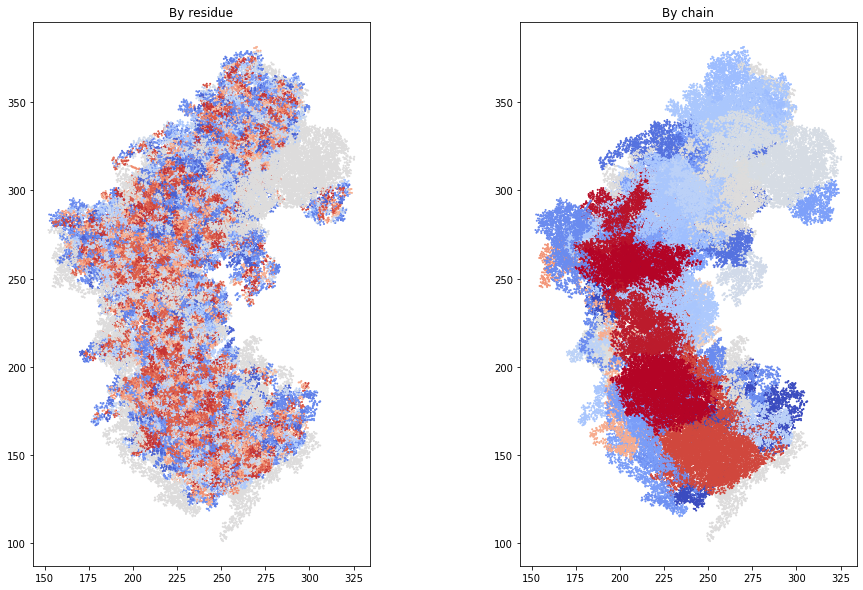

In [184]:
# Plot a smoothed by-residue hydrophobicity and a mean by chain
fig, ax = plt.subplots(1, 2, figsize=(16, 10))

z_order = np.argsort(
  np.concatenate([
    chain['atoms']
    for chain in pdbs[1]['chains']
  ], axis=0)[:,1][::-1]
)

colors=[
  # By residue
  smooth(
    np.concatenate([
      [residue_hydrophobicity[r] if r in residue_hydrophobicity else 0 for r in chain['atom_residues']]
      for chain in pdbs[1]['chains']
    ], axis=0)
  ),
  # By chain
  np.concatenate([
    np.tile(
      np.mean([residue_hydrophobicity[r] if r in residue_hydrophobicity else 0 for r in chain['atom_residues']], keepdims=True),
      chain['atoms'].shape[0]
    )
    for chain in pdbs[1]['chains']
  ], axis=0),
]

for i, c in enumerate(colors):
  ax[i].set_aspect('equal')
  cb = ax[i].scatter(
    np.concatenate([
      chain['atoms'][:,0]
      for chain in pdbs[1]['chains']
    ], axis=0)[z_order],
    np.concatenate([
      chain['atoms'][:,2]
      for chain in pdbs[1]['chains']
    ], axis=0)[z_order],
    s=1,
    c=c[z_order],
    cmap=plt.get_cmap('coolwarm'),
    vmin=-1 if i == 1 else -5,
    vmax=1 if i == 1 else 5
  )
  ax[i].set_title('By chain' if i == 1 else 'By residue')
#plt.colorbar(cb)